
# Import packages

In [122]:
import sys
import pandas as pd
import numpy as np
import glob
import os
import scipy.stats as st
import random
import matplotlib.pyplot as plt

sys.path.append('../../')
from utils import dataframe_utils

In [123]:
# # FOLD CHANGE FROM MEAN EXPRESSION
# def normalizer(array):
#     array_mean = np.mean(array)
#     normalized = [np.log2(tpm) for tpm in ((array + 1) / (array_mean + 1))]
#     return normalized

# def normalize_expression_per_gene(expression_df):
#     if 'TTHERM_ID' in expression_df.columns:
#         ttids = expression_df['TTHERM_ID'].values
#         data = expression_df[list(expression_df.columns)[1:]]
        
#         norm_expression_df = pd.DataFrame(data.apply(normalizer, axis=1).tolist(), columns=data.columns)

#         norm_expression_df['TTHERM_ID'] = ttids

#         columns = norm_expression_df.columns.tolist()

#         rearrangement = columns[-1:] + columns[:-1]

#         norm_expression_df = norm_expression_df[rearrangement]
#     else:
#         norm_expression_df = pd.DataFrame(expression_df.apply(normalizer, axis=1).tolist(), columns=expression_df.columns)

#     return norm_expression_df

# Z-SCORE
def normalizer(array):
    log_a = [np.log10(tpm + 1) for tpm in array]
    normalized = st.zscore(log_a)
    return normalized

def normalize_expression_per_gene(expression_df):
    if 'TTHERM_ID' in expression_df.columns:
        ttids = expression_df['TTHERM_ID'].values
        data = expression_df[list(expression_df.columns)[1:]]
        
        norm_expression_df = pd.DataFrame(data.apply(normalizer, axis=1).tolist(), columns=data.columns)

        norm_expression_df['TTHERM_ID'] = ttids

        columns = norm_expression_df.columns.tolist()

        rearrangement = columns[-1:] + columns[:-1]

        norm_expression_df = norm_expression_df[rearrangement]
    else:
        norm_expression_df = pd.DataFrame(expression_df.apply(normalizer, axis=1).tolist(), columns=expression_df.columns)

    return norm_expression_df

# # MIN-MAX
# def normalizer(array):
#     """
#     Normalizes the values of an array to range from zero to one
#     """
    
#     a = np.array(array)
    
#     normalized = (array - np.min(array)) / (np.max(array) - np.min(array))
    
#     return normalized

# def normalize_expression_per_gene(expression_df):
#     """
#     Function to normalize all gene expression to range from zero to one.
#     """
#     if 'TTHERM_ID' in expression_df.columns:
#         ttids = expression_df['TTHERM_ID'].values
#         data = expression_df[list(expression_df.columns)[1:]]
        
#         norm_expression_df = data.apply(lambda row: normalizer(row), axis=1)
#         norm_expression_df['TTHERM_ID'] = ttids
        
#         columns = norm_expression_df.columns.tolist()
        
#         rearrangment = columns[-1:] + columns[:-1]
        
#         norm_expression_df = norm_expression_df[rearrangment]
        
#     else:
#         norm_expression_df = expression_df.apply(lambda row: normalizer(row), axis=1)
    
#     return norm_expression_df



In [124]:
satellite_ttherm_ids = list((pd.read_csv('./selected-annotation-data.tsv', delimiter='\t'))['TTHERM_ID'].values)

In [125]:
len(satellite_ttherm_ids)

604

# Import the data for each timepoint

In [126]:
file_paths = sorted(glob.glob('./rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_*'))
file_paths

['./rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_000min_A',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_000min_B',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_030min_A',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_030min_B',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_060min_A',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_060min_B',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_090min_A',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_090min_B',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_120min_A',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_120min_B',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_150min_A',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_150min_B',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_

In [127]:
dict_tpms = {}

for fp in file_paths:
    split = ((os.path.splitext(os.path.basename(fp))[0]).split('_'))
    key = '_'.join(split[len(split)-2:len(split)])
    print(key)
    dict_tpms[key] = (pd.read_csv(os.path.join(fp, 'abundance.tsv'), delimiter='\t'))

print(np.unique([df.shape for df in dict_tpms.values()]))

000min_A
000min_B
030min_A
030min_B
060min_A
060min_B
090min_A
090min_B
120min_A
120min_B
150min_A
150min_B
180min_A
180min_B
210min_A
210min_B
240min_A
240min_B
[    5 25987]


In [128]:
dict_tpms['000min_A'].head()

,target_id,length,eff_length,est_counts,tpm
0,YF00013476.t1,7212,7022.640,757.0,1.229920
1,YF00013477.t1,2502,2312.640,273.0,1.346900
2,YF00036562.t1,4962,4772.640,14.0,0.033469
3,YF00036564.t1,6309,6119.640,630.0,1.174610
4,YF00013481.t1,966,776.636,6533.0,95.978700


In [129]:
def computeRPK(row):
    if not row['eff_length'] > 0:
        print('ZERO sequence length:', row['target_id'])
        print(row)
        return 'ZERO sequence length'
    return row['est_counts']/row['eff_length']

def computeTPM(row, normalization_factor):
    return row['rpk']/normalization_factor

def compute_tpm_columns(df_dict):
    df_tpm = {}
    normalization_factor_dict = {}
    for key, df in df_dict.items():
        tpm_df = df
        tpm_df['rpk'] = tpm_df.apply(computeRPK, axis=1)
        tpm_df = tpm_df.loc[tpm_df['rpk']!='ZERO sequence length']

        sum_rpk = tpm_df['rpk'].sum()

        normalization_factor = sum_rpk/1_000_000

        tpm_df['tpm_manual'] = tpm_df.apply(computeTPM, axis=1, args=(normalization_factor,))

        df_tpm[key] = tpm_df  
        normalization_factor_dict[key] = normalization_factor

    return df_tpm, normalization_factor_dict

def compute_cpm_columns(df_dict):
    df_cpm = {}
    for key, df in df_dict.items():
        cpm_df = df

        sum_count = cpm_df['est_counts'].sum()

        cpm_df['cpm_manual'] = (cpm_df['est_counts'] / sum_count) * 1_000_000

        df_cpm[key] = cpm_df  

    return df_cpm

In [130]:
dict_tpms, norm_factors_dict = compute_tpm_columns(dict_tpms)

In [131]:
dict_tpms['150min_A'].head()

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual
0,YF00013476.t1,7212,7025.980,764.0,1.43456,0.108739,1.434564
1,YF00013477.t1,2502,2315.980,2592.0,14.76500,1.119181,14.765009
2,YF00036562.t1,4962,4775.980,699.0,1.93085,0.146357,1.930849
3,YF00036564.t1,6309,6122.980,482.0,1.03853,0.078720,1.038527
4,YF00013481.t1,966,779.979,2761.0,46.70000,3.539839,46.700015


In [132]:
dict_cpms = compute_cpm_columns(dict_tpms)

In [133]:
dict_cpms['150min_A'].head()

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual,cpm_manual
0,YF00013476.t1,7212,7025.980,764.0,1.43456,0.108739,1.434564,16.841696
1,YF00013477.t1,2502,2315.980,2592.0,14.76500,1.119181,14.765009,57.138321
2,YF00036562.t1,4962,4775.980,699.0,1.93085,0.146357,1.930849,15.408830
3,YF00036564.t1,6309,6122.980,482.0,1.03853,0.078720,1.038527,10.625259
4,YF00013481.t1,966,779.979,2761.0,46.70000,3.539839,46.700015,60.863775


In [134]:
norm_factors_dict

{'000min_A': 0.08764359044702891,
 '000min_B': 0.10142149887215271,
 '030min_A': 0.09224228585052313,
 '030min_B': 0.08971928915246696,
 '060min_A': 0.08689457031699578,
 '060min_B': 0.110510607854403,
 '090min_A': 0.07984283822670517,
 '090min_B': 0.09409812434010506,
 '120min_A': 0.08049852282663537,
 '120min_B': 0.10143849606041971,
 '150min_A': 0.07579952343144356,
 '150min_B': 0.09527650682639892,
 '180min_A': 0.09132111691134094,
 '180min_B': 0.0917491736119316,
 '210min_A': 0.06972040366687281,
 '210min_B': 0.08735273419185882,
 '240min_A': 0.10089281480313546,
 '240min_B': 0.09428391975618013}

In [135]:
ttherm_id = 'YF00013476.t1'

dict_tpms['000min_A'].loc[dict_tpms['000min_A']['target_id'] == ttherm_id]

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual,cpm_manual
0,YF00013476.t1,7212,7022.64,757.0,1.22992,0.107794,1.229916,14.655096


In [136]:
dict_tpms['000min_A'].shape

(25987, 8)

## Checkout a single timepoint

In [137]:
num_nonzero = (dict_tpms['000min_A'].loc[dict_tpms['000min_A']['tpm'] != 0.0].shape)[0]

mean = dict_tpms['000min_A']['tpm'].mean()

std = dict_tpms['000min_A']['tpm'].std()

str_summary_wzeros = f'''WITH ZEROS...
MEAN: {mean}
MEDIAN: {dict_tpms['000min_A']['tpm'].median()}
STDEV: {std}
CV: {(std/mean)*100}
MAX: {dict_tpms['000min_A']['tpm'].max()}
MIN: {dict_tpms['000min_A']['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

df_tpm_wozeros = dict_tpms['000min_A'].loc[dict_tpms['000min_A']['tpm'] != 0.0]

mean_wozeros = df_tpm_wozeros['tpm'].mean()

std_wozeros = df_tpm_wozeros['tpm'].std()

str_summary_wozeros = f'''WITHOUT ZEROS...
MEAN: {mean_wozeros}
MEDIAN: {df_tpm_wozeros['tpm'].median()}
STDEV: {std_wozeros}
CV: {(std_wozeros/mean_wozeros)*100}
MAX: {df_tpm_wozeros['tpm'].max()}
MIN: {df_tpm_wozeros['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

print(str_summary_wzeros, '\n', str_summary_wozeros, sep='')


WITH ZEROS...
MEAN: 38.48077988601189
MEDIAN: 0.937477
STDEV: 380.2093962449458
CV: 988.0501314453749
MAX: 24066.6
MIN: 0.0
# GENES EXPRESSED: 22592

WITHOUT ZEROS...
MEAN: 44.26345728124074
MEDIAN: 1.4707050000000002
STDEV: 407.46499676954954
CV: 920.5448959411424
MAX: 24066.6
MIN: 7.03107e-11
# GENES EXPRESSED: 22592



# Create a dataframe containing all data at every timepoint (sorted by TTHERM_ID)

In [138]:
column_prefixes = sorted(list(dict_tpms.keys()))
column_prefixes

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [139]:
complete_data_df = None

for col_prefix in column_prefixes:
    curr_df = dict_tpms[col_prefix].sort_values(by='target_id')
    curr_df.rename(columns={col: (f'{col_prefix}_{col}') for col in list(curr_df.columns) if col != 'target_id'}, inplace=True)

    if complete_data_df is None:
        complete_data_df = curr_df
        continue

    complete_data_df = dataframe_utils.sql_query_df({'complete_data_df': complete_data_df, 'curr_df': curr_df},
                                                    '''SELECT * FROM complete_data_df
                                                       INNER JOIN curr_df USING(target_id)'''
                                                    )

complete_data_df.rename(columns={'target_id': 'TTHERM_ID'}, inplace=True)
complete_data_df


,TTHERM_ID,000min_A_length,000min_A_eff_length,000min_A_est_counts,000min_A_tpm,000min_A_rpk,000min_A_tpm_manual,000min_A_cpm_manual,000min_B_length,000min_B_eff_length,...,240min_A_rpk,240min_A_tpm_manual,240min_A_cpm_manual,240min_B_length,240min_B_eff_length,240min_B_est_counts,240min_B_tpm,240min_B_rpk,240min_B_tpm_manual,240min_B_cpm_manual
0,YF00000001.t1,420,233.375,12.000,0.586688,0.051419,0.586687,0.232313,420,235.226,...,0.047906,0.474826,0.193428,420,231.934,22.000,1.006050,0.094855,1.006052,0.417645
1,YF00000003.t1,4356,4166.640,11089.000,30.365900,2.661377,30.365906,214.676826,4356,4168.770,...,3.663745,36.313245,268.178556,4356,4165.140,16559.000,42.166400,3.975617,42.166434,314.353482
2,YF00000004.t1,1200,1010.640,102.000,1.151560,0.100926,1.151552,1.974663,1200,1012.770,...,1.399650,13.872646,24.776315,1200,1009.140,1254.000,13.179800,1.242642,13.179790,23.805741
3,YF00000005.t1,498,309.503,907.000,33.436500,2.930505,33.436612,17.559012,498,311.494,...,4.884668,48.414425,26.270983,498,307.998,1897.000,65.325400,6.159131,65.325359,36.012353
4,YF00000006.t1,1077,887.636,1321.000,16.980400,1.488223,16.980393,25.573820,1077,889.771,...,1.912463,18.955398,29.717511,1077,886.139,1695.000,20.287600,1.912792,20.287579,32.177617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25982,YF00038376.t1,2283,2093.640,130.557,0.711504,0.062359,0.711505,2.527510,2283,2095.770,...,0.109675,1.087042,4.030064,2283,2092.140,163.032,0.826504,0.077926,0.826503,3.094974
25983,YF00038377.t1,3402,3212.640,104.000,0.369361,0.032372,0.369361,2.013382,3402,3214.770,...,0.004052,0.040157,0.228596,3402,3211.140,17.000,0.056150,0.005294,0.056150,0.322725
25984,YF00038378.t1,927,737.636,134.000,2.072730,0.181661,2.072729,2.594165,927,739.771,...,0.249429,2.472213,3.217932,927,736.139,217.863,3.138960,0.295954,3.138962,4.135877
25985,YF00038707.t1,1434,1244.640,356.000,3.263530,0.286026,3.263519,6.891961,1434,1246.770,...,0.008866,0.087876,0.193428,1434,1243.140,18.000,0.153573,0.014479,0.153573,0.341709


# SATELLITE GENE COUNTS

In [140]:
(complete_data_df[['TTHERM_ID'] + [col for col in complete_data_df if 'counts' in col]].loc[complete_data_df['TTHERM_ID'].isin(satellite_ttherm_ids)])

,TTHERM_ID,000min_A_est_counts,000min_B_est_counts,030min_A_est_counts,030min_B_est_counts,060min_A_est_counts,060min_B_est_counts,090min_A_est_counts,090min_B_est_counts,120min_A_est_counts,120min_B_est_counts,150min_A_est_counts,150min_B_est_counts,180min_A_est_counts,180min_B_est_counts,210min_A_est_counts,210min_B_est_counts,240min_A_est_counts,240min_B_est_counts
68,YF00000081.t1,0.0,0.0,0.0,4.16127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169,YF00000208.t1,0.0,2.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181,YF00000224.t1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
217,YF00000266.t1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293,YF00000364.t1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25883,YF00038176.t1,0.0,0.0,1.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25909,YF00038249.t1,0.0,0.0,0.0,2.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25916,YF00038260.t1,1.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25940,YF00038296.t1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
# 10 reads cuttoff
complete_data_df['max_count'] = complete_data_df[[col for col in complete_data_df if 'counts' in col]].apply(lambda x: max(x), axis=1)

In [142]:
complete_data_df_filtered = complete_data_df.loc[complete_data_df['max_count'] > 10]
complete_data_df_filtered

,TTHERM_ID,000min_A_length,000min_A_eff_length,000min_A_est_counts,000min_A_tpm,000min_A_rpk,000min_A_tpm_manual,000min_A_cpm_manual,000min_B_length,000min_B_eff_length,...,240min_A_tpm_manual,240min_A_cpm_manual,240min_B_length,240min_B_eff_length,240min_B_est_counts,240min_B_tpm,240min_B_rpk,240min_B_tpm_manual,240min_B_cpm_manual,max_count
0,YF00000001.t1,420,233.375,12.000,0.586688,0.051419,0.586687,0.232313,420,235.226,...,0.474826,0.193428,420,231.934,22.000,1.006050,0.094855,1.006052,0.417645,45.000
1,YF00000003.t1,4356,4166.640,11089.000,30.365900,2.661377,30.365906,214.676826,4356,4168.770,...,36.313245,268.178556,4356,4165.140,16559.000,42.166400,3.975617,42.166434,314.353482,19653.000
2,YF00000004.t1,1200,1010.640,102.000,1.151560,0.100926,1.151552,1.974663,1200,1012.770,...,13.872646,24.776315,1200,1009.140,1254.000,13.179800,1.242642,13.179790,23.805741,3790.000
3,YF00000005.t1,498,309.503,907.000,33.436500,2.930505,33.436612,17.559012,498,311.494,...,48.414425,26.270983,498,307.998,1897.000,65.325400,6.159131,65.325359,36.012353,3726.000
4,YF00000006.t1,1077,887.636,1321.000,16.980400,1.488223,16.980393,25.573820,1077,889.771,...,18.955398,29.717511,1077,886.139,1695.000,20.287600,1.912792,20.287579,32.177617,2075.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25980,YF00038374.t1,2892,2702.640,864.000,3.647590,0.319687,3.647585,16.726556,2892,2704.770,...,2.592944,12.414534,2892,2701.140,784.000,3.078450,0.290248,3.078445,14.883334,1009.000
25982,YF00038376.t1,2283,2093.640,130.557,0.711504,0.062359,0.711505,2.527510,2283,2095.770,...,1.087042,4.030064,2283,2092.140,163.032,0.826504,0.077926,0.826503,3.094974,365.547
25983,YF00038377.t1,3402,3212.640,104.000,0.369361,0.032372,0.369361,2.013382,3402,3214.770,...,0.040157,0.228596,3402,3211.140,17.000,0.056150,0.005294,0.056150,0.322725,104.000
25984,YF00038378.t1,927,737.636,134.000,2.072730,0.181661,2.072729,2.594165,927,739.771,...,2.472213,3.217932,927,736.139,217.863,3.138960,0.295954,3.138962,4.135877,560.868


# SATELLITE GENE COUNTS AFTER FILTERING

In [143]:
(complete_data_df_filtered[['TTHERM_ID'] + [col for col in complete_data_df_filtered if 'counts' in col]].loc[complete_data_df_filtered['TTHERM_ID'].isin(satellite_ttherm_ids)])

,TTHERM_ID,000min_A_est_counts,000min_B_est_counts,030min_A_est_counts,030min_B_est_counts,060min_A_est_counts,060min_B_est_counts,090min_A_est_counts,090min_B_est_counts,120min_A_est_counts,120min_B_est_counts,150min_A_est_counts,150min_B_est_counts,180min_A_est_counts,180min_B_est_counts,210min_A_est_counts,210min_B_est_counts,240min_A_est_counts,240min_B_est_counts
3435,YF00004364.t1,80.71590,164.3550,70.28270,136.785000,100.75700,181.98200,114.00500,1.565300e+02,117.41900,2.208530e+02,90.34970,210.11400,74.78530,129.6380,62.366500,81.337400,79.5275,93.69520
3470,YF00004413.t1,80.71590,164.3550,70.28270,136.785000,100.75700,181.98200,114.00500,1.565300e+02,117.41900,2.208530e+02,90.34970,210.11400,74.78530,129.6380,62.366500,81.337400,79.5275,93.69520
5833,YF00007362.t1,10.17860,1.0000,8.00000,1.000000,9.25714,1.00000,2.00000,2.142860e+00,0.00000,4.000000e+00,0.00000,4.00000,3.00000,1.0000,2.000000,1.000000,12.1463,3.00000
5926,YF00007480.t1,63.00000,7.0000,10.00000,1.000000,4.00000,1.00000,2.00000,1.000000e+00,5.00000,1.000000e+00,2.00000,1.00000,3.00000,2.0000,5.000000,2.000000,9.0000,3.00000
6376,YF00008080.t1,110.00000,131.0000,79.00000,44.000000,25.00000,51.00000,25.00000,4.500000e+01,23.00000,4.900000e+01,20.00000,37.00000,21.00000,40.0000,28.000000,17.000000,82.0000,68.00000
6464,YF00008190.t1,157.00000,53.0000,1.00000,2.000000,2.00000,2.00000,0.00000,0.000000e+00,2.00000,0.000000e+00,3.00000,1.00000,0.00000,1.0000,0.000000,1.000000,3.0000,1.00000
7146,YF00009147.t1,6701.00000,918.0000,5450.00000,675.000000,3689.00000,819.00000,3083.00000,6.270000e+02,4115.00000,1.018000e+03,3201.00000,961.00000,2675.00000,1005.0000,2071.000000,827.000000,4534.0000,877.00000
8811,YF00011495.t1,46.00000,44.0000,6.00000,16.000000,3.00000,22.00000,3.00000,1.700000e+01,7.00000,1.800000e+01,4.00000,15.00000,14.00000,17.0000,13.000000,12.000000,27.0000,44.00000
9059,YF00011860.t1,15.00000,2.0000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000e+00,0.00000,0.000000e+00,0.00000,0.00000,0.00000,0.0000,0.000000,0.000000,0.0000,0.00000
10562,YF00013907.t1,4.62374,0.0000,9.45290,0.000000,13.74320,7.88177,4.54404,7.610430e+00,21.79750,1.192040e+01,5.00273,8.26287,9.12629,0.0000,4.876280,4.679750,17.9404,4.59089


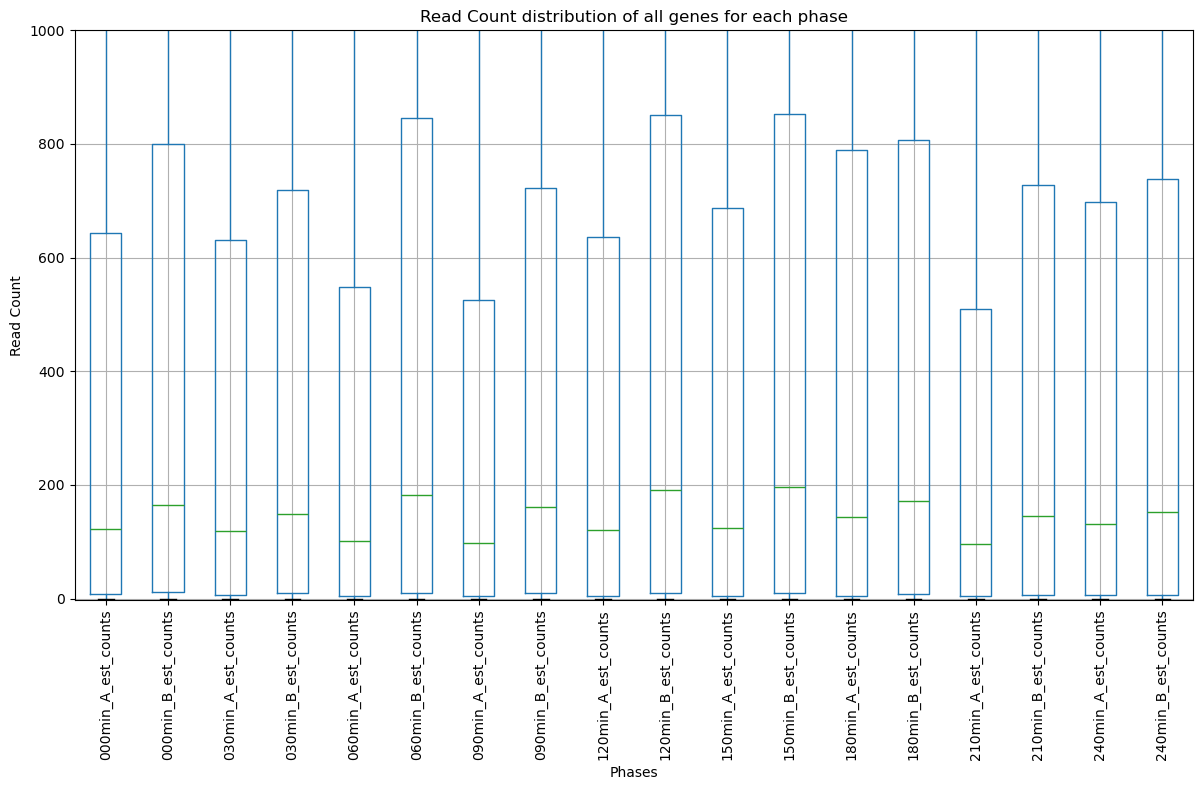

In [144]:
# Assuming you have your gene expression dataset loaded into a DataFrame called 'data'
# Columns: Genes (rows), Phases (columns)
# Rows: Genes, Expression values across phases

df_data = complete_data_df.loc[:, [col for col in complete_data_df if 'counts' in col]]

# Plot boxplot for each phase
plt.figure(figsize=(12, 8))
df_data.boxplot(rot=90)
plt.title('Read Count distribution of all genes for each phase')
plt.xlabel('Phases')
plt.ylabel('Read Count')
plt.tight_layout()
plt.ylim(top=1000)
plt.ylim(bottom=-2.5)
plt.show()

# Create a dataframe containing all TPM data at every timepoint (sorted by TTHERM_ID)

In [145]:
columns = sorted(list(dict_tpms.keys()))
columns

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [146]:
curr_df = dict_tpms['000min_A'].sort_values(by='target_id')
dict_df_all_tpm = {'TTHERM_ID': curr_df['target_id'].values}
print(curr_df.head(3))

for col in columns:
    curr_df = dict_tpms[col].sort_values(by='target_id')
    print(curr_df.head(3))
    dict_df_all_tpm[col] = (curr_df)['tpm'].values

df_all_tpm = pd.DataFrame(dict_df_all_tpm)

print(df_all_tpm.shape)

df_all_tpm.head()

           target_id  length  eff_length  est_counts        tpm       rpk  \
20015  YF00000001.t1     420     233.375        12.0   0.586688  0.051419   
20016  YF00000003.t1    4356    4166.640     11089.0  30.365900  2.661377   
20017  YF00000004.t1    1200    1010.640       102.0   1.151560  0.100926   

       tpm_manual  cpm_manual  
20015    0.586687    0.232313  
20016   30.365906  214.676826  
20017    1.151552    1.974663  
           target_id  length  eff_length  est_counts        tpm       rpk  \
20015  YF00000001.t1     420     233.375        12.0   0.586688  0.051419   
20016  YF00000003.t1    4356    4166.640     11089.0  30.365900  2.661377   
20017  YF00000004.t1    1200    1010.640       102.0   1.151560  0.100926   

       tpm_manual  cpm_manual  
20015    0.586687    0.232313  
20016   30.365906  214.676826  
20017    1.151552    1.974663  
           target_id  length  eff_length  est_counts       tpm       rpk  \
20015  YF00000001.t1     420     235.226        40

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,1.87789,0.556894,1.46126,0.714378,1.93705,0.250387,1.10541,0.474825,1.00605
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,38.39890,47.206000,36.22920,51.271300,43.32920,46.160600,48.83810,36.313300,42.16640
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,24.96380,14.598100,18.05180,11.361800,16.56940,9.478250,15.73490,13.872700,13.17980
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,106.06300,53.745700,124.78900,55.339100,89.40470,55.587700,67.44460,48.414400,65.32540
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,17.97100,23.469000,15.33890,25.727200,19.34310,23.332400,21.26720,18.955400,20.28760


In [147]:
all_cols = list(df_all_tpm.columns)
all_cols

['TTHERM_ID',
 '000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [148]:
tpm_cols = [col for col in df_all_tpm.columns[1:] if 'diff' not in col]
tpm_cols

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

# Create a dataframe containing all CPM data at every timepoint (sorted by TTHERM_ID)

In [149]:
columns = sorted(list(dict_tpms.keys()))
columns

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [150]:
curr_df = dict_cpms['000min_A'].sort_values(by='target_id')
dict_df_all_cpm = {'TTHERM_ID': curr_df['target_id'].values}
print(curr_df.head(3))

for col in columns:
    curr_df = dict_cpms[col].sort_values(by='target_id')
    print(curr_df.head(3))
    dict_df_all_cpm[col] = (curr_df)['cpm_manual'].values

df_all_cpm = pd.DataFrame(dict_df_all_cpm)

print(df_all_cpm.shape)

df_all_cpm.head()

           target_id  length  eff_length  est_counts        tpm       rpk  \
20015  YF00000001.t1     420     233.375        12.0   0.586688  0.051419   
20016  YF00000003.t1    4356    4166.640     11089.0  30.365900  2.661377   
20017  YF00000004.t1    1200    1010.640       102.0   1.151560  0.100926   

       tpm_manual  cpm_manual  
20015    0.586687    0.232313  
20016   30.365906  214.676826  
20017    1.151552    1.974663  
           target_id  length  eff_length  est_counts        tpm       rpk  \
20015  YF00000001.t1     420     233.375        12.0   0.586688  0.051419   
20016  YF00000003.t1    4356    4166.640     11089.0  30.365900  2.661377   
20017  YF00000004.t1    1200    1010.640       102.0   1.151560  0.100926   

       tpm_manual  cpm_manual  
20015    0.586687    0.232313  
20016   30.365906  214.676826  
20017    1.151552    1.974663  
           target_id  length  eff_length  est_counts       tpm       rpk  \
20015  YF00000001.t1     420     235.226        40

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.232313,0.818733,0.380388,0.672996,0.164525,0.660954,0.272507,0.752236,0.483136,0.900434,0.220441,0.725330,0.274608,0.833987,0.096955,0.439391,0.193428,0.417645
1,YF00000003.t1,214.676826,280.866260,318.080794,246.473501,358.334461,266.156878,446.298079,270.163185,389.737202,324.956745,328.920096,316.419888,356.770522,336.645938,324.459021,354.329292,268.178556,314.353482
2,YF00000004.t1,1.974663,5.526446,43.516435,54.243463,77.943504,40.355985,74.530621,53.320226,43.833631,51.344767,24.733486,38.354592,19.112707,31.142292,16.070247,27.521885,24.776315,23.805741
3,YF00000005.t1,17.559012,62.264624,32.409093,62.207247,36.853498,66.737506,35.448598,62.347052,32.677577,67.252440,28.128278,81.896395,28.266302,51.137637,28.528931,35.610683,26.270983,36.012353
4,YF00000006.t1,25.573820,19.096941,22.423897,26.381436,38.683834,26.853631,38.968478,27.456598,37.596782,32.475665,34.939907,28.639561,37.987420,31.915255,34.709795,32.634804,29.717511,32.177617


# Jaccard filtering: https://academic.oup.com/bioinformatics/article/29/17/2146/240530#SEC2.2

In [151]:
cols_a = [col for col in df_all_cpm if 'A' in col]
cols_a

['000min_A',
 '030min_A',
 '060min_A',
 '090min_A',
 '120min_A',
 '150min_A',
 '180min_A',
 '210min_A',
 '240min_A']

In [152]:
def jaccard_similarity(set1, set2):
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))
     
    return intersection / union

In [153]:
np.percentile(df_all_cpm.loc[:, tpm_cols].to_numpy().flatten(), 14)

0.017584326000681605

In [154]:
percentiles = np.arange(14, 31, 0.1)

tpm_cutoffs = []

jaccard_similarity_means = []

for _percentile in percentiles:

    tpm_cutoff = np.percentile(df_all_cpm.loc[:, tpm_cols].to_numpy().flatten(), _percentile)

    tpm_cutoffs.append(tpm_cutoff)

    jaccard_similarities = []

    for col_a in cols_a:
        col_b = col_a.replace('A', 'B')

        jaccard_similarities.append(jaccard_similarity(set(df_all_cpm.loc[df_all_cpm[col_a] > tpm_cutoff, 'TTHERM_ID'].values), 
                                                        set(df_all_cpm.loc[df_all_cpm[col_b] > tpm_cutoff, 'TTHERM_ID'].values)))

    jaccard_similarity_means.append(np.mean(jaccard_similarities))


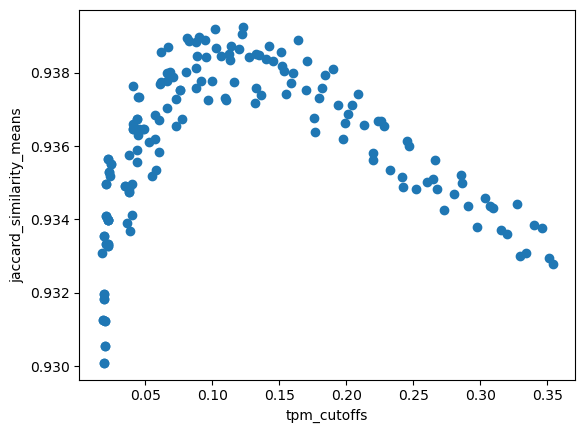

In [155]:
plt.scatter(x=tpm_cutoffs, y=jaccard_similarity_means)
plt.xlabel('tpm_cutoffs')
plt.ylabel('jaccard_similarity_means')
plt.show()

In [156]:
print(np.argmax(jaccard_similarity_means))
print(jaccard_similarity_means[np.argmax(jaccard_similarity_means)])
print(tpm_cutoffs[np.argmax(jaccard_similarity_means)])

105
0.9392519177609808
0.12309028200477125


In [157]:
CPM_THRESHOLD = tpm_cutoffs[np.argmax(jaccard_similarity_means)]

In [158]:
df_all_cpm['max_cpm'] = df_all_cpm[tpm_cols].apply(lambda x: max(x), axis=1)

In [159]:
df_all_cpm_filtered = df_all_cpm.loc[df_all_cpm['max_cpm'] > CPM_THRESHOLD]
df_all_cpm_filtered.shape, df_all_cpm.shape

((21524, 20), (25987, 20))

In [160]:
((df_all_cpm_filtered[['TTHERM_ID'] + tpm_cols].loc[df_all_cpm_filtered['TTHERM_ID'].isin(satellite_ttherm_ids)])).shape

(47, 19)

# Translate to TTHERM_ID

In [161]:
df_y_to_ttherm = pd.read_csv('../tgd2024/yf_ttherm_mapping_feb2024.csv')
dict_y_to_ttherm = {yf: ttherm for yf, ttherm in zip(df_y_to_ttherm['yf2024'].values, df_y_to_ttherm['ttherm2021'].values)}

In [162]:
dict_y_to_ttherm

{'YF00003507': 'TTHERM_00655860',
 'YF00028628': 'TTHERM_00927120',
 'YF00019461': 'TTHERM_00716070',
 'YF00018024': 'TTHERM_00188330',
 'YF00011744': 'TTHERM_00264990',
 'YF00000692': 'TTHERM_00301690',
 'YF00020018': 'TTHERM_00571650',
 'YF00027771': 'TTHERM_001414123',
 'YF00005353': 'TTHERM_00146080',
 'YF00007877': 'TTHERM_000672289',
 'YF00013833': 'TTHERM_00335730',
 'YF00009042': 'TTHERM_00427470',
 'YF00015223': 'TTHERM_00170160',
 'YF00000272': 'TTHERM_00155480',
 'YF00015664': 'TTHERM_00660400',
 'YF00005973': 'TTHERM_00522430',
 'YF00028690': 'TTHERM_00945200',
 'YF00001875': 'TTHERM_000492719',
 'YF00004732': 'TTHERM_00467760',
 'YF00018327': 'TTHERM_00823880',
 'YF00001113': 'TTHERM_00217210',
 'YF00016026': 'TTHERM_00225760',
 'YF00013217': 'TTHERM_00134890',
 'YF00009571': 'TTHERM_00709740',
 'YF00004778': 'TTHERM_00467320',
 'YF00001824': 'TTHERM_00492320',
 'YF00025848': 'TTHERM_00979890',
 'YF00017079': 'TTHERM_000043960',
 'YF00016244': 'TTHERM_00856580',
 'YF000005

In [163]:
# df_all_tpm['TTHERM_ID'] = [dict_y_to_ttherm[id.replace('.t1', '')] if id.replace('.t1', '') in dict_y_to_ttherm else id for id in df_all_tpm['TTHERM_ID'].values]
df_all_tpm.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
24108,YF00035425.t1,0.008964,0.007742,0.005684,0.008756,0.000000,0.018976,0.000000,0.013924,0.022761,0.002580,0.006904,0.013729,0.005742,0.005714,0.007527,0.009013,0.000000,0.016671
13199,YF00017470.t1,1.052510,0.857897,1.486020,1.330970,1.810990,1.458340,1.937700,1.603340,2.632620,1.710550,2.803730,1.604080,1.814900,1.729880,1.518570,1.661630,1.799110,1.496410
22386,YF00029754.t1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3488,YF00004446.t1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21149,YF00027819.t1,0.062918,0.115536,0.008264,0.029773,0.021440,0.030411,0.018027,0.042124,0.042814,0.028031,0.053427,0.037077,0.055673,0.046960,0.034615,0.044398,0.032740,0.036824
3995,YF00005044.t1,10.474000,14.609000,10.924700,11.704200,9.887010,11.034500,8.031600,8.891630,7.274750,8.829700,6.612450,11.514400,6.755610,8.415850,6.879410,7.766870,5.990310,7.924360
16800,YF00022198.t1,0.000000,0.012653,0.000000,0.028697,0.000000,0.011694,0.000000,0.000000,0.015896,0.012621,0.000000,0.026789,0.000000,0.000000,0.000000,0.000000,0.012778,0.000000
24132,YF00035466.t1,0.072008,0.087801,0.094487,0.071753,0.114983,0.086536,0.095253,0.088248,0.126268,0.123227,0.165194,0.148952,0.129763,0.105647,0.074361,0.108898,0.061442,0.081149
21325,YF00028041.t1,0.043452,0.000000,0.041832,0.000000,0.000000,0.034905,0.047626,0.000000,0.047011,0.000000,0.000000,0.000000,0.000000,0.000000,0.111359,0.000000,0.000000,0.000000
18319,YF00024127.t1,0.275502,0.860252,0.526692,1.345530,1.062140,1.895280,0.850175,1.529000,0.598234,1.407650,0.534826,1.007710,0.316104,0.711088,0.437762,0.682038,0.782448,0.529399


In [164]:
target_ttherms = [
'YF00038249.t1',
'YF00038144.t1',
'YF00037875.t1',
'YF00036137.t1',
'YF00035125.t1',
'YF00032971.t1',
'YF00031769.t1',
'YF00030211.t1',
'YF00029957.t1',
'YF00029882.t1',
'YF00029765.t1',
'YF00028141.t1',
'YF00027752.t1',
'YF00027453.t1',
'YF00027225.t1',
'YF00026417.t1',
'YF00025835.t1',
'YF00022485.t1',
'YF00021713.t1',
'YF00019938.t1',
'YF00016416.t1',
'YF00014101.t1',
'YF00012770.t1',
'YF00011364.t1',
'YF00011107.t1',
'YF00010540.t1',
'YF00008765.t1',
'YF00008689.t1',
'YF00008085.t1',
'YF00008072.t1',
'YF00007477.t1',
'YF00005570.t1',
'YF00004316.t1',
'YF00003349.t1',
'YF00002595.t1',
'YF00000081.t1',
]

df_all_tpm.loc[df_all_tpm['TTHERM_ID'].isin(target_ttherms)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
68,YF00000081.t1,0.000000,0.0,0.0,0.036996,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2097,YF00002595.t1,0.013493,0.0,0.0,0.000000,0.013636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2644,YF00003349.t1,0.000000,0.0,0.0,0.387257,0.407557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3396,YF00004316.t1,0.000000,0.0,0.0,0.001761,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4418,YF00005570.t1,0.048289,0.0,0.0,0.047110,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5923,YF00007477.t1,0.049753,0.0,0.0,0.024293,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6368,YF00008072.t1,0.000000,0.0,0.0,0.009042,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6379,YF00008085.t1,0.000000,0.0,0.0,0.000000,0.071076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6816,YF00008689.t1,0.000000,0.0,0.0,0.000000,0.051713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6873,YF00008765.t1,0.000000,0.0,0.0,0.191437,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check out genes with all zeros

In [165]:
rows_with_all_zeros = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).all(axis=1)]

print(rows_with_all_zeros.shape)

rows_with_all_zeros.head()

(1339, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
15,YF00000019.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,YF00000082.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,YF00000084.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,YF00000119.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,YF00000123.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check out rows with one nonzero

In [166]:
rows_with_one_nonzero = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1) == 17]

print(rows_with_one_nonzero.shape)

rows_with_one_nonzero.head()

(480, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
68,YF00000081.t1,0.0,0.000000,0.0,0.036996,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
169,YF00000208.t1,0.0,0.051487,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
181,YF00000224.t1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.044273,0.0
217,YF00000266.t1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.083607,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
293,YF00000364.t1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.028285,0.0


## Check out the distribution of the number of zeros

In [167]:
num_zeros_counts = {}

for i in range(20):
    num_zeros = (df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1)
    
    rows_with_num_zeros = df_all_tpm[num_zeros == i]
    
    num_zeros_counts[i] = len(rows_with_num_zeros)

for num_zeros, count in num_zeros_counts.items():
    print(f"Number of rows with {num_zeros} zeros: {count}")

Number of rows with 0 zeros: 19964
Number of rows with 1 zeros: 569
Number of rows with 2 zeros: 371
Number of rows with 3 zeros: 322
Number of rows with 4 zeros: 244
Number of rows with 5 zeros: 231
Number of rows with 6 zeros: 236
Number of rows with 7 zeros: 220
Number of rows with 8 zeros: 204
Number of rows with 9 zeros: 194
Number of rows with 10 zeros: 202
Number of rows with 11 zeros: 198
Number of rows with 12 zeros: 187
Number of rows with 13 zeros: 212
Number of rows with 14 zeros: 216
Number of rows with 15 zeros: 277
Number of rows with 16 zeros: 321
Number of rows with 17 zeros: 480
Number of rows with 18 zeros: 1339
Number of rows with 19 zeros: 0


## Filter out genes with all zeros

In [168]:
df_no_all_zeros = df_all_tpm[~df_all_tpm.isin(rows_with_all_zeros)].dropna()
df_no_all_zeros.reset_index()
print(df_all_tpm.shape[0]-df_no_all_zeros.shape[0])
df_no_all_zeros.head()

1339


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,1.87789,0.556894,1.46126,0.714378,1.93705,0.250387,1.10541,0.474825,1.00605
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,38.39890,47.206000,36.22920,51.271300,43.32920,46.160600,48.83810,36.313300,42.16640
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,24.96380,14.598100,18.05180,11.361800,16.56940,9.478250,15.73490,13.872700,13.17980
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,106.06300,53.745700,124.78900,55.339100,89.40470,55.587700,67.44460,48.414400,65.32540
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,17.97100,23.469000,15.33890,25.727200,19.34310,23.332400,21.26720,18.955400,20.28760


In [169]:
df_no_all_zeros.shape

(24648, 19)

## Check out the genes which display the highest expression

In [170]:
df_no_all_zeros.loc[:, df_no_all_zeros.columns[1:]].max(axis=None)

56844.4

In [171]:
max_tpm_ttherms = []

for col in df_no_all_zeros.columns[1:]:
    max_tpm = df_no_all_zeros[col].max()
    max_tpm_ttherm = df_no_all_zeros['TTHERM_ID'].loc[df_no_all_zeros[col] == df_no_all_zeros[col].max()].values[0]
    print(col, 'MAX:', max_tpm, '|', max_tpm_ttherm)
    max_tpm_ttherms.append(max_tpm_ttherm)
    

000min_A MAX: 24066.6 | YF00003862.t1
000min_B MAX: 50334.6 | YF00003862.t1
030min_A MAX: 36006.6 | YF00016492.t1
030min_B MAX: 53698.0 | YF00016492.t1
060min_A MAX: 25488.8 | YF00016492.t1
060min_B MAX: 52352.1 | YF00016492.t1
090min_A MAX: 29475.1 | YF00003862.t1
090min_B MAX: 49362.8 | YF00003862.t1
120min_A MAX: 30933.5 | YF00003862.t1
120min_B MAX: 51420.7 | YF00003862.t1
150min_A MAX: 27235.0 | YF00003862.t1
150min_B MAX: 56844.4 | YF00003862.t1
180min_A MAX: 25523.5 | YF00003862.t1
180min_B MAX: 40729.6 | YF00003862.t1
210min_A MAX: 23139.8 | YF00003862.t1
210min_B MAX: 29244.5 | YF00003862.t1
240min_A MAX: 25990.6 | YF00003862.t1
240min_B MAX: 31894.7 | YF00003862.t1


In [172]:
np.unique(max_tpm_ttherms)

array(['YF00003862.t1', 'YF00016492.t1'], dtype='<U13')

Identifier	Gene Name	Alias Name(s)	Description
TTHERM_00105330	RPS28	7.m00482, PreTt23033	RPS28 40S ribosomal protein S28e putative; Homolog of yeast RPS28- human RPS28;

Identifier	Gene Name	Alias Name(s)	Description
TTHERM_00682940		103.m00122, 3734.m00034, PreTt16131	60S ribosomal protein L29

In [173]:
df_no_all_zeros_cols = df_no_all_zeros.columns[1:]
df_no_all_zeros_cols

Index(['000min_A', '000min_B', '030min_A', '030min_B', '060min_A', '060min_B',
       '090min_A', '090min_B', '120min_A', '120min_B', '150min_A', '150min_B',
       '180min_A', '180min_B', '210min_A', '210min_B', '240min_A', '240min_B'],
      dtype='object')

In [174]:
df_no_all_zeros_cols_a = [col for col in df_no_all_zeros_cols if 'A' in col]
df_no_all_zeros_cols_a

['000min_A',
 '030min_A',
 '060min_A',
 '090min_A',
 '120min_A',
 '150min_A',
 '180min_A',
 '210min_A',
 '240min_A']

## Compute the TPM difference fractions between duplicates

In [175]:
def compute_diff_fraction(row):
    values = row.values
    if all(value == 0 for value in values):
        return 1
    return min(values) / max(values)

for col_a in df_no_all_zeros_cols_a:
    col_b = col_a.replace('A', 'B')
    df_no_all_zeros[f'{col_a.replace("_A", "")}_diff'] = df_no_all_zeros[[col_a, col_b]].apply(compute_diff_fraction, axis=1)

In [176]:
df_no_all_zeros.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,240min_B,000min_diff,030min_diff,060min_diff,090min_diff,120min_diff,150min_diff,180min_diff,210min_diff,240min_diff
10913,YF00014385.t1,0.266180,0.826667,2.765750,4.193820,10.464200,8.749280,18.594200,10.998200,29.366800,...,8.161920,0.321992,0.659482,0.836116,0.591486,0.520009,0.469535,0.925210,0.481790,0.832400
13336,YF00017643.t1,0.371494,0.282430,0.403417,0.264280,0.431976,0.407251,0.403315,0.447930,0.505253,...,0.604647,0.760255,0.655104,0.942763,0.900397,0.917515,0.558722,0.782339,0.902591,0.726174
2307,YF00002869.t1,0.010870,0.000000,0.020735,0.010618,0.032946,0.000000,0.000000,0.010147,0.011814,...,0.000000,0.000000,0.512086,0.000000,0.000000,0.792954,1.000000,0.000000,0.000000,1.000000
15426,YF00020383.t1,1.691510,1.060020,1.577690,1.782580,1.495280,1.244180,1.209380,1.734880,1.305240,...,1.913400,0.626671,0.885060,0.832072,0.697097,0.945573,0.913096,0.658916,0.938279,0.830506
16739,YF00022123.t1,1.002220,2.746930,1.000770,2.323150,1.422840,1.940670,0.675856,1.537010,0.664946,...,0.980530,0.364851,0.430781,0.733169,0.439721,0.516431,0.524480,0.835304,0.767076,0.714755
7321,YF00009407.t1,13.891900,6.146130,9.321140,6.744710,9.029270,6.385550,5.541110,6.063030,6.380420,...,9.238150,0.442425,0.723593,0.707206,0.913918,0.999056,0.823743,0.953156,0.878265,0.916601
24164,YF00035518.t1,7.162410,5.979400,5.225510,6.566420,5.194310,5.554840,4.695020,5.331320,3.882940,...,5.289690,0.834831,0.795793,0.935096,0.880649,0.774616,0.829500,0.750371,0.842645,0.946906
5478,YF00006896.t1,44.840400,30.784200,38.523300,35.899800,33.140100,30.231500,37.986500,35.912300,43.985900,...,51.478900,0.686528,0.931898,0.912233,0.945396,0.883269,0.628822,0.730925,0.898380,0.869181
21559,YF00028375.t1,0.286249,1.326610,0.307252,0.873783,0.132565,0.826190,0.183236,0.779535,0.246250,...,0.566325,0.215775,0.351634,0.160453,0.235058,0.347288,0.223983,0.173385,0.388533,0.385787
16513,YF00021819.t1,3.525800,4.253270,5.930910,5.042140,3.255360,4.525090,3.548910,4.346620,3.941080,...,9.990540,0.828962,0.850146,0.719402,0.816476,0.869215,0.821627,0.985239,0.977340,0.834054


### Sanity check

In [177]:
[(str(num)).zfill(3) for num in np.arange(0, 241, 30)]

['000', '030', '060', '090', '120', '150', '180', '210', '240']

In [178]:
random_ttherms = [random.choice(df_no_all_zeros['TTHERM_ID'].values) for _ in range(10)]
random_time = random.choice([f'{((str(num)).zfill(3))}min' for num in np.arange(0, 241, 30)])

print('TIME:', random_time)

for ttherm in random_ttherms:
    val_a = df_no_all_zeros[f'{random_time}_A'].loc[df_no_all_zeros['TTHERM_ID'] == ttherm].values[0]
    val_b = df_no_all_zeros[f'{random_time}_B'].loc[df_no_all_zeros['TTHERM_ID'] == ttherm].values[0]
    val_diff = df_no_all_zeros[f'{random_time}_diff'].loc[df_no_all_zeros['TTHERM_ID'] == ttherm].values[0]

    manual_val_diff = 1 if all(value == 0 for value in (val_a, val_b)) else min((val_a, val_b))/max((val_a, val_b))

    print(f'{ttherm} | {min([val_a, val_b])}/{max([val_a, val_b])} = {val_diff} | {manual_val_diff} | {val_diff == (manual_val_diff)}')


TIME: 090min
YF00005872.t1 | 0.368003/0.370106 = 0.9943178440771023 | 0.9943178440771023 | True
YF00006143.t1 | 0.141026/0.385147 = 0.3661614915863294 | 0.3661614915863294 | True
YF00018650.t1 | 0.0533732/0.187891 = 0.2840646970850121 | 0.2840646970850121 | True
YF00010136.t1 | 2.77262/6.51276 = 0.4257211996142956 | 0.4257211996142956 | True
YF00024785.t1 | 0.575234/1.59334 = 0.36102401245183074 | 0.36102401245183074 | True
YF00024337.t1 | 3.56495/3.74569 = 0.9517472081245377 | 0.9517472081245377 | True
YF00010973.t1 | 0.206539/0.399009 = 0.5176299281469842 | 0.5176299281469842 | True
YF00029818.t1 | 5.00984/7.3229 = 0.6841333351541056 | 0.6841333351541056 | True
YF00021191.t1 | 7.05859/8.84848 = 0.7977178001193425 | 0.7977178001193425 | True
YF00004907.t1 | 0.0885203/0.175803 = 0.5035198489218046 | 0.5035198489218046 | True


## Compute the differences between TPM and ∆TPM for the two repeated cycles

In [179]:
df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,240min_B,000min_diff,030min_diff,060min_diff,090min_diff,120min_diff,150min_diff,180min_diff,210min_diff,240min_diff
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,...,1.00605,0.349915,0.658082,0.288600,0.411949,0.618540,0.381105,0.368797,0.226511,0.471970
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,...,42.16640,0.935637,0.674782,0.636341,0.527537,0.726040,0.767470,0.845097,0.945176,0.861190
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,...,13.17980,0.438090,0.924041,0.444262,0.624695,0.981000,0.808678,0.685710,0.602371,0.950053
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,...,65.32540,0.347249,0.605125,0.640750,0.647872,0.559557,0.430693,0.618973,0.824198,0.741127
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,...,20.28760,0.608873,0.979575,0.595808,0.615465,0.751623,0.653581,0.751854,0.911488,0.934334


In [180]:
percent_diff_col_pairs = [['000min_A', '210min_A'], ['000min_B', '210min_B'], ['000min_diff', '210min_diff'], ['030min_A', '240min_A'], ['030min_B', '240min_B'], ['030min_diff', '240min_diff']]
print_cols = []

for pair in percent_diff_col_pairs:
    col_1 = pair[0]
    col_2 = pair[1]
    new_col_name = f'percent_diff_{col_1}_{col_2}'
    df_no_all_zeros[new_col_name] = np.nan_to_num(100 * (np.absolute(df_no_all_zeros[col_1] - df_no_all_zeros[col_2])/((df_no_all_zeros[col_1] + df_no_all_zeros[col_2]) / 2)), nan=0)
    print_cols.append(new_col_name)

df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,150min_diff,180min_diff,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,...,0.381105,0.368797,0.226511,0.471970,80.351462,41.066544,42.817066,65.906145,34.859223,32.938792
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,...,0.767470,0.845097,0.945176,0.861190,41.279034,40.306841,1.014387,18.134331,35.709355,24.272358
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,...,0.808678,0.685710,0.602371,0.950053,156.666770,142.743128,31.578443,55.915955,67.690624,2.775984
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,...,0.430693,0.618973,0.824198,0.741127,49.764446,35.234035,81.429034,21.996720,41.737449,20.204465
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,...,0.653581,0.751854,0.911488,0.934334,31.513564,69.153107,39.808363,26.876962,31.504415,4.727528


In [181]:
print_cols_padding = max([len(col) for col in print_cols])

for col in print_cols:
    print(f'{" "*(print_cols_padding-len(col))}{col}:', df_no_all_zeros[col].mean())

      percent_diff_000min_A_210min_A: 59.11356903632433
      percent_diff_000min_B_210min_B: 61.73439886489784
percent_diff_000min_diff_210min_diff: 46.92748442282115
      percent_diff_030min_A_240min_A: 47.88076125829554
      percent_diff_030min_B_240min_B: 49.5260898592382
percent_diff_030min_diff_240min_diff: 45.404817883612246


In [182]:
print_cols_padding = max([len(col) for col in print_cols])

for col in print_cols:
    print(f'{" "*(print_cols_padding-len(col))}{col}:', df_no_all_zeros[col].median())

      percent_diff_000min_A_210min_A: 40.89135867696572
      percent_diff_000min_B_210min_B: 46.728151145794094
percent_diff_000min_diff_210min_diff: 27.285694891864622
      percent_diff_030min_A_240min_A: 31.784761067668946
      percent_diff_030min_B_240min_B: 34.253135067630836
percent_diff_030min_diff_240min_diff: 26.31634139452639


In [183]:
print_cols_padding = max([len(col) for col in print_cols])

for col in print_cols:
    print(f'{" "*(print_cols_padding-len(col))}{col}:', df_no_all_zeros[col].std())

      percent_diff_000min_A_210min_A: 57.13897201004343
      percent_diff_000min_B_210min_B: 55.06584335965166
percent_diff_000min_diff_210min_diff: 55.12837005190752
      percent_diff_030min_A_240min_A: 51.161114073388234
      percent_diff_030min_B_240min_B: 50.831290618236764
percent_diff_030min_diff_240min_diff: 54.04997974161522


## Take a look at the distribution of differences

In [184]:
diff_cols = [col for col in list(df_no_all_zeros.columns) if 'diff' in col and 'percent_diff' not in col]
diff_cols

['000min_diff',
 '030min_diff',
 '060min_diff',
 '090min_diff',
 '120min_diff',
 '150min_diff',
 '180min_diff',
 '210min_diff',
 '240min_diff']

In [185]:
diffs_flattened = df_no_all_zeros.loc[:, diff_cols].to_numpy().flatten()
diffs_flattened.shape, diffs_flattened

((221832,),
 array([0.34991471, 0.6580823 , 0.28860017, ..., 0.        , 1.        ,
        1.        ]))

In [186]:
st.percentileofscore(diffs_flattened, 0, kind='weak')

6.209654152692127

In [187]:
sorted(diffs_flattened, reverse=True)

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [188]:
# plt.hist(diffs_flattened, bins=10000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='line at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('∆TPM Between Duplicates')
# plt.ylabel('# of ∆TPMs')
# plt.title(f'Distribution of ∆TPM Between Duplicates')

# plt.show()

# plt.hist(diffs_flattened, bins=10000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='line at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('∆TPM Between Duplicates')
# plt.ylabel('# of ∆TPMs')
# plt.title(f'Distribution of ∆TPM Between Duplicates')

# plt.ylim(top=200)

# plt.show()

In [189]:
tpms_flattened = df_no_all_zeros[tpm_cols].to_numpy().flatten()
tpms_flattened.shape, tpms_flattened

((443664,),
 array([0.586688, 1.67666 , 0.941571, ..., 0.      , 0.      , 0.      ]))

## Take a look at the distribution of TPMs

In [190]:
# plt.hist(tpms_flattened, bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.show()

# plt.hist(tpms_flattened, bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.ylim(top=50)

# plt.show()

In [191]:
sorted(tpms_flattened)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

# Take the geometric mean of each set of timepoint duplicates

In [192]:
def geo_mean_df_of_duplicates(df: pd.DataFrame):
    return_df = df.loc[:, df.columns[0:1]]
    num_df = df.loc[:, df.columns[1:]]

    idxa = 0
    idxb = 1

    num_df_cols = list(num_df.columns)

    while idxb < len(num_df_cols):
        col_a_split = num_df_cols[idxa].split('_')
        col_name = '_'.join(col_a_split[:len(col_a_split)-1])
        return_df[col_name] = np.sqrt(num_df[num_df_cols[idxa]] * num_df[num_df_cols[idxb]])

        idxa += 1
        idxb += 1
    
    return return_df

def ari_mean_df_of_duplicates(df: pd.DataFrame):
    return_df = df.loc[:, df.columns[0:1]]
    num_df = df.loc[:, df.columns[1:]]

    idxa = 0
    idxb = 1

    num_df_cols = list(num_df.columns)

    while idxb < len(num_df_cols):
        col_a_split = num_df_cols[idxa].split('_')
        col_name = '_'.join(col_a_split[:len(col_a_split)-1])
        return_df[col_name] = num_df[num_df_cols[idxa]] + num_df[num_df_cols[idxb]] / 2

        idxa += 1
        idxb += 1
    
    return return_df

In [193]:
df_all_tpms_averaged_geo = geo_mean_df_of_duplicates(df_no_all_zeros.loc[:, all_cols])
df_all_tpms_averaged_geo

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,YF00000001.t1,1.256461,0.753414,0.939548,1.345603,1.022637,1.021710,0.696428,0.724483,0.691157
1,YF00000003.t1,37.597501,37.616212,42.540945,40.596981,42.575327,43.098935,44.722498,42.112618,39.130565
2,YF00000004.t1,8.047902,33.952269,27.944957,24.941037,19.089894,14.321346,12.531916,14.774490,13.521812
3,YF00000005.t1,76.249407,81.721247,81.177229,76.019846,75.501193,83.100607,70.496820,57.142715,56.237799
4,YF00000006.t1,12.228857,18.994551,18.771678,18.872893,20.536830,19.865220,21.244316,20.078055,19.610191
...,...,...,...,...,...,...,...,...,...,...
25982,YF00038376.t1,0.940133,1.407921,1.542528,1.275465,1.011045,0.740933,0.911942,0.969431,0.947862
25983,YF00038377.t1,0.129766,0.036646,0.030387,0.044673,0.042410,0.053397,0.060143,0.050815,0.047485
25984,YF00038378.t1,4.221523,3.606703,3.521457,3.489134,4.087515,4.829793,3.484258,3.042917,2.785708
25985,YF00038707.t1,0.430747,0.059011,0.053490,0.056918,0.139824,0.158857,0.135369,0.106722,0.116170


In [194]:
df_all_tpms_averaged_geo_flattened = df_all_tpms_averaged_geo.iloc[:, 1:].to_numpy().flatten()

In [195]:
# plt.hist(df_all_tpms_averaged_geo_flattened, bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.show()

# plt.hist(df_all_tpms_averaged_geo.iloc[:, 1:].to_numpy().flatten(), bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.ylim(top=50)

# plt.show()

In [196]:
df_all_tpms_averaged_ari = ari_mean_df_of_duplicates(df_no_all_zeros.loc[:, all_cols])
df_all_tpms_averaged_ari

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,YF00000001.t1,2.147445,1.629145,1.695747,2.139595,2.156337,1.818449,2.062244,1.342823,0.977850
1,YF00000003.t1,54.232350,53.462500,60.172050,57.606350,62.001900,61.864850,66.409500,66.994750,57.396500
2,YF00000004.t1,14.948640,48.280650,39.536150,37.645650,32.262850,23.732700,21.308525,22.671250,20.462600
3,YF00000005.t1,126.479700,133.246100,135.999150,127.048750,132.935850,152.458550,117.198550,91.651800,81.077100
4,YF00000006.t1,17.571050,26.983000,26.660500,26.852000,29.705500,28.202500,31.009300,30.744900,29.099200
...,...,...,...,...,...,...,...,...,...,...
25982,YF00038376.t1,1.379632,1.991199,2.205315,1.891740,1.471922,1.048152,1.318834,1.408066,1.500292
25983,YF00038377.t1,0.241591,0.052728,0.043129,0.064844,0.060391,0.079514,0.089062,0.084381,0.068232
25984,YF00038378.t1,7.401020,7.217435,6.745220,5.999345,7.217140,9.407335,6.300475,4.981475,4.041690
25985,YF00038707.t1,1.481125,0.091677,0.087270,0.111786,0.197887,0.231200,0.201285,0.173547,0.164663


In [197]:
df_all_tpms_averaged_ari_flattened = df_all_tpms_averaged_ari.iloc[:, 1:].to_numpy().flatten()

In [198]:
# plt.hist(df_all_tpms_averaged_ari_flattened, bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.show()

# plt.hist(df_all_tpms_averaged_ari.iloc[:, 1:].to_numpy().flatten(), bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.ylim(top=50)

# plt.show()

# Check out the TPM values at different percentiles

In [199]:
print('% ALL TPMs <= 0: ', st.percentileofscore(tpms_flattened, 0, kind='weak'))
print('% ALL TPMs == 0: ', (1 - (np.count_nonzero(tpms_flattened)/len(tpms_flattened))) * 100)
print('TPM AT 10th PERCENTILE OF ALL TPMs: ', np.percentile(tpms_flattened, 10))
print('TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS: ', np.percentile(tpms_flattened[tpms_flattened != 0], 10))

% ALL TPMs <= 0:  9.109371055573586
% ALL TPMs == 0:  9.10937105557359
TPM AT 10th PERCENTILE OF ALL TPMs:  0.00575609
TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS:  0.0549957


In [200]:
print('% ALL TPMs <= 0: ', st.percentileofscore(df_all_tpms_averaged_geo_flattened, 0, kind='weak'))
print('% ALL TPMs == 0: ', (1 - (np.count_nonzero(df_all_tpms_averaged_geo_flattened)/len(df_all_tpms_averaged_geo_flattened))) * 100)
print('TPM AT 10th PERCENTILE OF ALL TPMs: ', np.percentile(df_all_tpms_averaged_geo_flattened, 10))
print('TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS: ', np.percentile(df_all_tpms_averaged_geo_flattened[df_all_tpms_averaged_geo_flattened != 0], 10))

% ALL TPMs <= 0:  12.354845108009664
% ALL TPMs == 0:  12.354845108009659
TPM AT 10th PERCENTILE OF ALL TPMs:  0.0
TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS:  0.07451087620197164


In [201]:
print('% ALL TPMs <= 0: ', st.percentileofscore(df_all_tpms_averaged_ari_flattened, 0, kind='weak'))
print('% ALL TPMs == 0: ', (1 - (np.count_nonzero(df_all_tpms_averaged_ari_flattened)/len(df_all_tpms_averaged_ari_flattened))) * 100)
print('TPM AT 10th PERCENTILE OF ALL TPMs: ', np.percentile(df_all_tpms_averaged_ari_flattened, 10))
print('TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS: ', np.percentile(df_all_tpms_averaged_ari_flattened[df_all_tpms_averaged_ari_flattened != 0], 10))

% ALL TPMs <= 0:  6.021674059648743
% ALL TPMs == 0:  6.02167405964874
TPM AT 10th PERCENTILE OF ALL TPMs:  0.019397283000000015
TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS:  0.063471515


# Graphing exploration for filtering

In [202]:
satellite_ttherm_ids[: 20]

['YF00035400.t1',
 'YF00035004.t1',
 'YF00035003.t1',
 'YF00034427.t1',
 'YF00033466.t1',
 'YF00030066.t1',
 'YF00028669.t1',
 'YF00026033.t1',
 'YF00025356.t1',
 'YF00024649.t1',
 'YF00022767.t1',
 'YF00022073.t1',
 'YF00021259.t1',
 'YF00020335.t1',
 'YF00020008.t1',
 'YF00019262.t1',
 'YF00018447.t1',
 'YF00017437.t1',
 'YF00012493.t1',
 'YF00012376.t1']

In [203]:
df_tpm_data = df_all_tpm[tpm_cols]

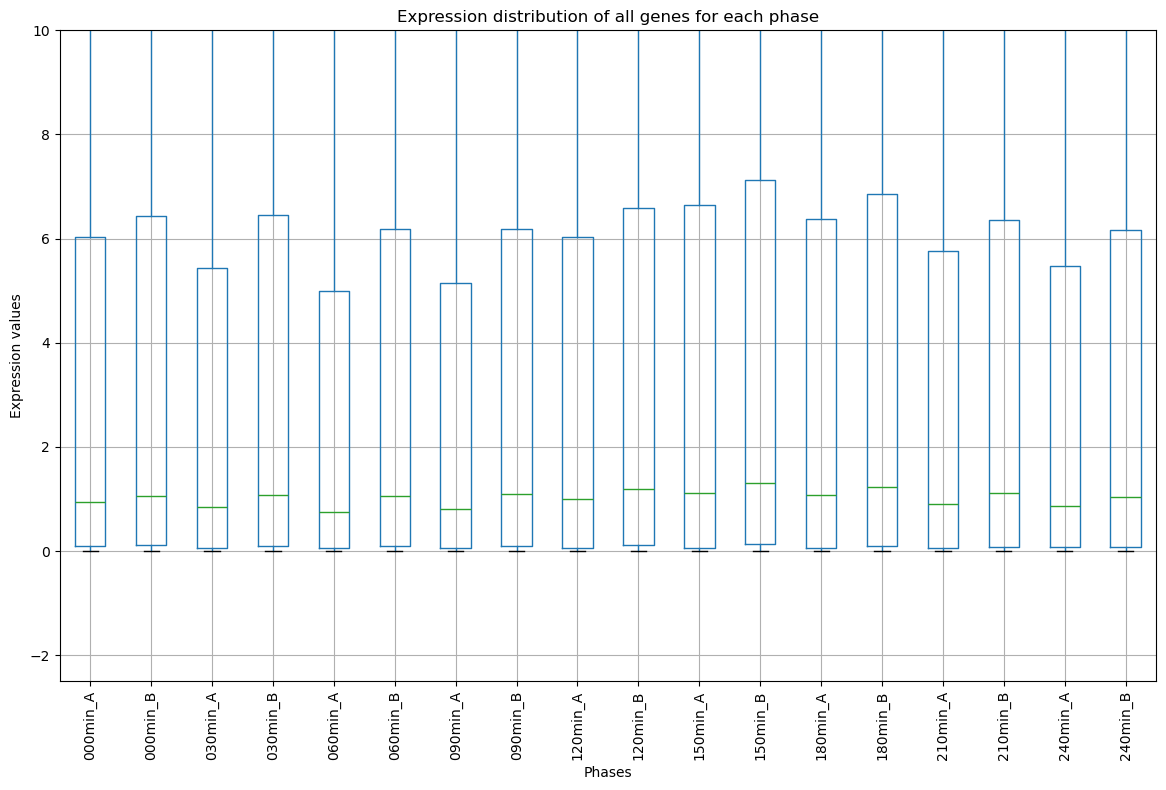

In [204]:
# Assuming you have your gene expression dataset loaded into a DataFrame called 'data'
# Columns: Genes (rows), Phases (columns)
# Rows: Genes, Expression values across phases

# Plot boxplot for each phase
plt.figure(figsize=(12, 8))
df_tpm_data.boxplot(rot=90)
plt.title('Expression distribution of all genes for each phase')
plt.xlabel('Phases')
plt.ylabel('Expression values')
plt.tight_layout()
plt.ylim(top=10)
plt.ylim(bottom=-2.5)
plt.show()


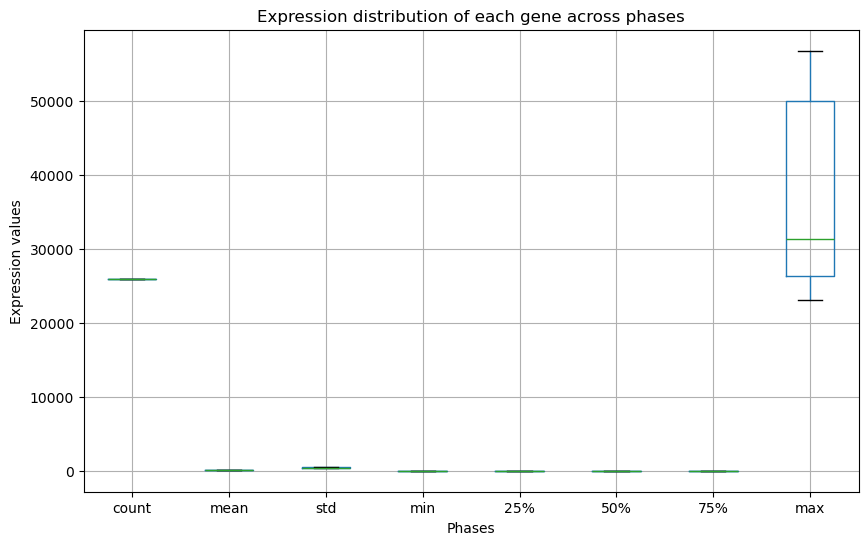

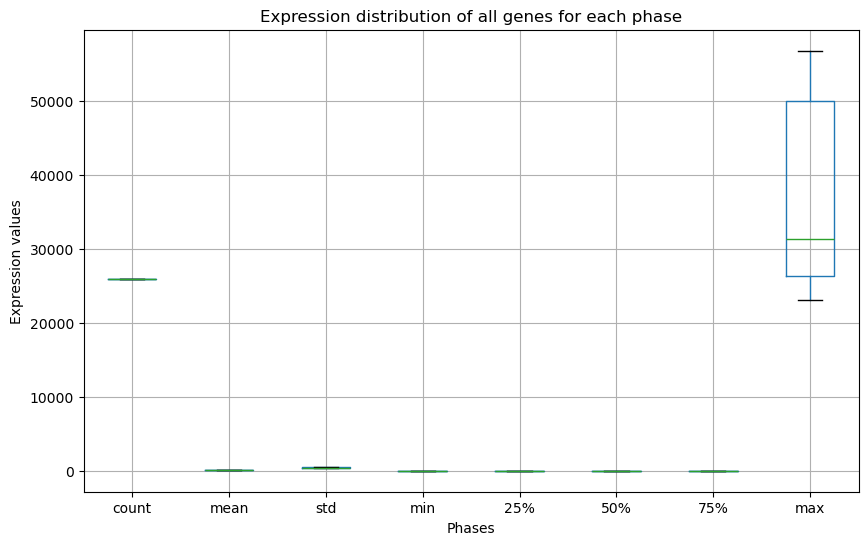

In [205]:
# Assuming you have your gene expression dataset loaded into a DataFrame called 'data'
# Columns: Genes (rows), Phases (columns)
# Rows: Genes, Expression values across phases

# Step 1: Phase-specific outliers
# Calculate expression distribution for each gene across phases
gene_expression_distribution = df_tpm_data.describe().T  # Transpose for easier processing

# Plot boxplots or histograms for each gene
plt.figure(figsize=(10, 6))
gene_expression_distribution.boxplot()
plt.title('Expression distribution of each gene across phases')
plt.xlabel('Phases')
plt.ylabel('Expression values')
plt.show()

# Step 2: Gene-specific outliers
# Calculate expression distribution for each phase across genes
phase_expression_distribution = df_tpm_data.describe()

# Plot boxplots or histograms for each phase
plt.figure(figsize=(10, 6))
phase_expression_distribution.T.boxplot()
plt.title('Expression distribution of all genes for each phase')
plt.xlabel('Phases')
plt.ylabel('Expression values')
plt.show()

In [206]:
# # Identify genes with consistently low or high expression values across phases
# gene_outliers = []
# for gene in data.index:
#     if (data.loc[gene] < threshold).all() or (data.loc[gene] > threshold).all():
#         gene_outliers.append(gene)

# # Filter out genes with consistent outlier behavior
# filtered_data = data.drop(gene_outliers, axis=0)

# Filter out genes

In [207]:
tpm_cols

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [208]:
df_no_all_zeros['max_tpm'] = df_no_all_zeros[tpm_cols].apply(lambda x: max(x), axis=1)
df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,180min_diff,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,...,0.368797,0.226511,0.471970,80.351462,41.066544,42.817066,65.906145,34.859223,32.938792,1.93705
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,...,0.845097,0.945176,0.861190,41.279034,40.306841,1.014387,18.134331,35.709355,24.272358,59.07130
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,...,0.685710,0.602371,0.950053,156.666770,142.743128,31.578443,55.915955,67.690624,2.775984,43.23010
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,...,0.618973,0.824198,0.741127,49.764446,35.234035,81.429034,21.996720,41.737449,20.204465,124.78900
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,...,0.751854,0.911488,0.934334,31.513564,69.153107,39.808363,26.876962,31.504415,4.727528,25.72720


In [209]:
TPM_THRESHOLD_PERCENTILE = 0

In [210]:
np.percentile(tpms_flattened[tpms_flattened != 0], TPM_THRESHOLD_PERCENTILE)

2.1616e-11

In [211]:
st.percentileofscore(tpms_flattened[tpms_flattened != 0], np.percentile(tpms_flattened[tpms_flattened != 0], TPM_THRESHOLD_PERCENTILE), kind='weak')

0.0002479857358604733

In [212]:
df_tpm_filtered = df_no_all_zeros.loc[df_no_all_zeros['max_tpm'] > np.percentile(tpms_flattened[tpms_flattened != 0], TPM_THRESHOLD_PERCENTILE)]
df_no_all_zeros.shape, df_tpm_filtered.shape

((24648, 35), (24648, 35))

In [213]:
df_tpm_filtered.loc[df_tpm_filtered['TTHERM_ID'].isin(target_ttherms)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,180min_diff,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm
68,YF00000081.t1,0.000000,0.0,0.0,0.036996,0.000000,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,200.0,200.0,0.036996
2097,YF00002595.t1,0.013493,0.0,0.0,0.000000,0.013636,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,200.0,0.0,200.0,0.0,0.0,0.0,0.013636
2644,YF00003349.t1,0.000000,0.0,0.0,0.387257,0.407557,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,200.0,200.0,0.407557
3396,YF00004316.t1,0.000000,0.0,0.0,0.001761,0.000000,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,200.0,200.0,0.001761
4418,YF00005570.t1,0.048289,0.0,0.0,0.047110,0.000000,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,200.0,0.0,200.0,0.0,200.0,200.0,0.048289
5923,YF00007477.t1,0.049753,0.0,0.0,0.024293,0.000000,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,200.0,0.0,200.0,0.0,200.0,200.0,0.049753
6368,YF00008072.t1,0.000000,0.0,0.0,0.009042,0.000000,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,200.0,200.0,0.009042
6379,YF00008085.t1,0.000000,0.0,0.0,0.000000,0.071076,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071076
6816,YF00008689.t1,0.000000,0.0,0.0,0.000000,0.051713,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051713
6873,YF00008765.t1,0.000000,0.0,0.0,0.191437,0.000000,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,200.0,200.0,0.191437


In [214]:
diff_cols

['000min_diff',
 '030min_diff',
 '060min_diff',
 '090min_diff',
 '120min_diff',
 '150min_diff',
 '180min_diff',
 '210min_diff',
 '240min_diff']

In [215]:
df_no_all_zeros['min_diff'] = df_no_all_zeros[diff_cols].apply(lambda x: np.min(x[x != 0]) if len(x[x != 0]) > 0 else 0, axis=1)
df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm,min_diff
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,...,0.226511,0.471970,80.351462,41.066544,42.817066,65.906145,34.859223,32.938792,1.93705,0.226511
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,...,0.945176,0.861190,41.279034,40.306841,1.014387,18.134331,35.709355,24.272358,59.07130,0.527537
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,...,0.602371,0.950053,156.666770,142.743128,31.578443,55.915955,67.690624,2.775984,43.23010,0.438090
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,...,0.824198,0.741127,49.764446,35.234035,81.429034,21.996720,41.737449,20.204465,124.78900,0.347249
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,...,0.911488,0.934334,31.513564,69.153107,39.808363,26.876962,31.504415,4.727528,25.72720,0.595808


In [216]:
df_no_all_zeros_zero_min_diffs = df_no_all_zeros.loc[df_no_all_zeros['min_diff'] == 0].loc[:, ['TTHERM_ID']+diff_cols]
df_no_all_zeros_zero_min_diffs.shape

(8, 10)

In [217]:
df_no_all_zeros.loc[df_no_all_zeros['TTHERM_ID']=='YF00000043.t1'].loc[:, ['TTHERM_ID'] + diff_cols]

,TTHERM_ID,000min_diff,030min_diff,060min_diff,090min_diff,120min_diff,150min_diff,180min_diff,210min_diff,240min_diff
33,YF00000043.t1,0.850832,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


In [218]:
DIFF_THRESHOLD_PERCENTILE = 0

In [219]:
np.percentile(diffs_flattened[diffs_flattened != 0], DIFF_THRESHOLD_PERCENTILE)

3.6976948485487384e-10

In [220]:
st.percentileofscore(diffs_flattened[diffs_flattened != 0], np.percentile(diffs_flattened[diffs_flattened != 0], DIFF_THRESHOLD_PERCENTILE), kind='weak')

0.0004806375176033491

In [221]:
df_diff_filtered = df_no_all_zeros.loc[df_no_all_zeros['min_diff'] > np.percentile(diffs_flattened[diffs_flattened != 0], DIFF_THRESHOLD_PERCENTILE)]
df_no_all_zeros.shape, df_diff_filtered.shape

((24648, 36), (24639, 36))

In [222]:
list(np.unique(max_tpm_ttherms))

['YF00003862.t1', 'YF00016492.t1']

In [223]:
df_diff_filtered.loc[df_diff_filtered['TTHERM_ID'].isin(list(np.unique(max_tpm_ttherms)))]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm,min_diff
3053,YF00003862.t1,24066.6,50334.6,25377.6,44694.1,24843.3,48432.8,29475.1,49362.8,30933.50,...,0.791253,0.814888,3.926586,53.004118,49.334224,2.386691,33.423686,35.739102,56844.4,0.478132
12414,YF00016492.t1,23639.3,37978.6,36006.6,53698.0,25488.8,52352.1,12918.2,42735.0,8111.06,...,0.712036,0.914881,59.216352,71.228734,13.428372,44.627504,72.942719,30.823687,53698.0,0.232730


In [224]:
df_filtered = df_diff_filtered.merge(df_tpm_filtered, how='inner', on='TTHERM_ID')
print('# genes in df_tpm_filtered:', df_tpm_filtered.shape[0])
print('# genes in df_diff_filtered:', df_diff_filtered.shape[0])
print('# genes in df_filtered:', df_filtered.shape[0])

# genes in df_tpm_filtered: 24648
# genes in df_diff_filtered: 24639
# genes in df_filtered: 24639


In [225]:
df_no_all_zeros.loc[df_no_all_zeros['TTHERM_ID'].isin(list(np.unique(max_tpm_ttherms)))]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm,min_diff
3053,YF00003862.t1,24066.6,50334.6,25377.6,44694.1,24843.3,48432.8,29475.1,49362.8,30933.50,...,0.791253,0.814888,3.926586,53.004118,49.334224,2.386691,33.423686,35.739102,56844.4,0.478132
12414,YF00016492.t1,23639.3,37978.6,36006.6,53698.0,25488.8,52352.1,12918.2,42735.0,8111.06,...,0.712036,0.914881,59.216352,71.228734,13.428372,44.627504,72.942719,30.823687,53698.0,0.232730


In [226]:
df_filtered_diffs_flattened = df_diff_filtered.loc[:, diff_cols].to_numpy().flatten()

In [227]:
# plt.hist(df_filtered_diffs_flattened, bins=10000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='line at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('∆TPM Between Duplicates')
# plt.ylabel('# of ∆TPMs')
# plt.title(f'Distribution of ∆TPM Between Duplicates')

# plt.show()

# plt.hist(df_filtered_diffs_flattened, bins=10000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='line at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('∆TPM Between Duplicates')
# plt.ylabel('# of ∆TPMs')
# plt.title(f'Distribution of ∆TPM Between Duplicates')

# plt.ylim(top=200)

# plt.show()

# Export the filtered TPM data to CSV

# FILTER BY RAW COUNT SELECTION

In [228]:
# df_filtered = df_no_all_zeros # FIXME
# df_filtered = df_no_all_zeros.loc[df_no_all_zeros['TTHERM_ID'].isin(complete_data_df_filtered['TTHERM_ID'].values)]
df_filtered = df_all_tpm.loc[df_all_tpm['TTHERM_ID'].isin(df_all_cpm_filtered['TTHERM_ID'].values)]

In [229]:
df_filtered.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,1.87789,0.556894,1.46126,0.714378,1.93705,0.250387,1.10541,0.474825,1.00605
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,38.39890,47.206000,36.22920,51.271300,43.32920,46.160600,48.83810,36.313300,42.16640
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,24.96380,14.598100,18.05180,11.361800,16.56940,9.478250,15.73490,13.872700,13.17980
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,106.06300,53.745700,124.78900,55.339100,89.40470,55.587700,67.44460,48.414400,65.32540
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,17.97100,23.469000,15.33890,25.727200,19.34310,23.332400,21.26720,18.955400,20.28760


In [230]:
df_filtered[tpm_cols].max(axis=None)

56844.4

In [231]:
df_filtered.loc[:, all_cols].to_csv('./tpm_kallisto.csv', index=False)

# Normalize expression per gene with zscore

In [232]:
normalized_tpm_df = normalize_expression_per_gene(df_filtered)
normalized_tpm_df.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,-0.908308,1.145299,-0.115611,0.766885,-1.409084,0.675171,-0.773370,0.968484,0.305886,1.429972,-0.982752,0.815823,-0.604338,1.509883,-1.843747,0.202541,-1.195423,0.012691
1,YF00000003.t1,-1.384332,-1.069767,0.328203,-1.538512,0.806536,-1.342437,1.786059,-1.261999,1.256096,-0.271852,0.712453,-0.548217,1.107472,0.303403,0.605484,0.874904,-0.537208,0.173715
2,YF00000004.t1,-2.772364,-2.061972,0.595705,0.699049,1.336810,0.271938,1.255485,0.635449,0.587698,0.612757,-0.079833,0.192026,-0.395900,0.081926,-0.620590,0.015784,-0.144561,-0.209407
3,YF00000005.t1,-2.252246,0.920244,-0.486757,1.027941,-0.177026,1.166451,-0.354959,0.954118,-0.538537,1.212648,-0.836164,1.705023,-0.748526,0.696042,-0.735077,-0.153981,-1.149135,-0.250056
4,YF00000006.t1,-0.381327,-2.390854,-1.038386,-0.954197,1.130309,-1.012028,1.090819,-0.918048,1.039469,-0.147575,0.961683,-0.798596,1.346442,0.156791,0.937282,0.550695,0.072922,0.354599


Sanity check

In [233]:
row_to_check = normalized_tpm_df.loc[2, normalized_tpm_df.columns[1:]] 

row_mean = np.mean(row_to_check)
row_std = np.std(row_to_check)

print(row_mean)
print(row_std)

9.251858538542972e-17
1.0000000000000002


In [234]:
normalized_tpm_df.shape

(21524, 19)

In [235]:
normalized_tpm_df

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,-0.908308,1.145299,-0.115611,0.766885,-1.409084,0.675171,-0.773370,0.968484,0.305886,1.429972,-0.982752,0.815823,-0.604338,1.509883,-1.843747,0.202541,-1.195423,0.012691
1,YF00000003.t1,-1.384332,-1.069767,0.328203,-1.538512,0.806536,-1.342437,1.786059,-1.261999,1.256096,-0.271852,0.712453,-0.548217,1.107472,0.303403,0.605484,0.874904,-0.537208,0.173715
2,YF00000004.t1,-2.772364,-2.061972,0.595705,0.699049,1.336810,0.271938,1.255485,0.635449,0.587698,0.612757,-0.079833,0.192026,-0.395900,0.081926,-0.620590,0.015784,-0.144561,-0.209407
3,YF00000005.t1,-2.252246,0.920244,-0.486757,1.027941,-0.177026,1.166451,-0.354959,0.954118,-0.538537,1.212648,-0.836164,1.705023,-0.748526,0.696042,-0.735077,-0.153981,-1.149135,-0.250056
4,YF00000006.t1,-0.381327,-2.390854,-1.038386,-0.954197,1.130309,-1.012028,1.090819,-0.918048,1.039469,-0.147575,0.961683,-0.798596,1.346442,0.156791,0.937282,0.550695,0.072922,0.354599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21519,YF00038374.t1,1.343482,0.248341,1.851154,1.003218,-1.761950,-0.157650,-1.517537,-0.935043,-1.087410,-1.193667,-0.183480,-0.635254,0.854074,0.359943,0.586729,0.891477,-0.217585,0.551157
21520,YF00038376.t1,-1.136331,-0.573521,-0.134804,-0.214171,2.368956,0.600735,2.097000,0.508385,0.755565,-0.453156,0.199039,-1.803984,-0.100376,-0.832815,-0.037491,-0.604878,0.094640,-0.732793
21521,YF00038377.t1,3.593190,1.641330,0.158593,-0.582674,-0.415353,-0.747574,-0.362234,-0.461796,-0.313632,-0.546988,-0.270375,-0.286052,-0.252450,-0.208865,-0.140690,-0.117769,-0.455675,-0.230989
21522,YF00038378.t1,-1.257593,1.178486,-0.441369,1.296370,-1.220148,1.071324,-1.139011,0.610398,-0.790530,1.126130,-0.541076,1.965006,-0.508293,0.818623,-0.975148,0.054094,-0.888703,-0.358559


# MEAN TYPE SELECTION

In [236]:
df_filtered_averaged = ari_mean_df_of_duplicates(normalized_tpm_df.loc[:, all_cols])
# df_filtered_averaged = geo_mean_df_of_duplicates(df_filtered.loc[:, all_cols])
df_filtered_averaged

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,YF00000001.t1,1.087494,0.062343,0.288486,1.121427,0.938596,0.513654,0.588010,-0.395171,-1.189078
1,YF00000003.t1,-0.905666,-1.135244,-0.449407,-0.633952,0.084375,0.005519,0.606145,0.606300,-0.450351
2,YF00000004.t1,-1.764120,1.367454,0.899681,0.929298,0.572841,-0.005924,-0.228369,-0.056497,-0.249264
3,YF00000005.t1,0.676865,0.939428,0.988971,0.684849,0.794566,1.330760,0.328503,-0.728549,-1.274163
4,YF00000006.t1,-2.910047,-0.389043,-0.466618,-0.398314,0.333266,-0.125375,0.625432,0.587156,0.250221
...,...,...,...,...,...,...,...,...,...,...
21519,YF00038374.t1,1.173918,0.122243,-0.916418,-1.478748,-1.285407,-0.208217,0.653308,0.782685,0.057993
21520,YF00038376.t1,-0.640923,0.970307,1.649235,0.886168,-0.353636,-1.854172,-0.851560,-0.557558,-0.271757
21521,YF00038377.t1,1.720627,-0.790350,-0.928691,-0.618612,-0.682176,-0.412277,-0.279209,-0.345607,-0.571169
21522,YF00038378.t1,0.957801,0.686296,0.501818,0.215133,0.855592,1.710860,0.331049,-0.390257,-1.067982


In [237]:
df_filtered.loc[:, all_cols]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.586688,1.676660,0.941571,1.430780,0.396730,1.374670,0.642154,1.558820,1.161550,1.877890,0.556894,1.461260,0.714378,1.937050,0.250387,1.105410,0.474825,1.006050
1,YF00000003.t1,30.365900,32.454800,43.555100,29.390200,48.144600,30.636400,59.071300,31.162300,52.888100,38.398900,47.206000,36.229200,51.271300,43.329200,46.160600,48.838100,36.313300,42.166400
2,YF00000004.t1,1.151560,2.628590,24.640100,26.665600,43.230100,19.205500,40.661300,25.400900,24.489500,24.963800,14.598100,18.051800,11.361800,16.569400,9.478250,15.734900,13.872700,13.179800
3,YF00000005.t1,33.436500,96.289700,60.380000,99.781000,66.930200,104.456000,63.086300,97.374600,59.348300,106.063000,53.745700,124.789000,55.339100,89.404700,55.587700,67.444600,48.414400,65.325400
4,YF00000006.t1,16.980400,10.338900,14.464300,14.765900,24.434200,14.558100,24.204800,14.897200,23.909600,17.971000,23.469000,15.338900,25.727200,19.343100,23.332400,21.267200,18.955400,20.287600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25980,YF00038374.t1,3.647590,2.879830,4.053340,3.394040,1.785290,2.628630,1.899820,2.192120,2.112930,2.058870,2.613210,2.353860,3.287310,2.951880,3.102440,3.313830,2.592950,3.078450
25982,YF00038376.t1,0.711504,0.873992,1.011280,0.985719,2.010960,1.264390,1.881850,1.230940,1.321600,0.910697,1.122450,0.536917,1.022470,0.797299,1.043070,0.864546,1.087040,0.826504
25983,YF00038377.t1,0.369361,0.199358,0.084467,0.031224,0.043009,0.019740,0.046778,0.039724,0.050239,0.033726,0.053329,0.052208,0.054612,0.057738,0.062647,0.064302,0.040157,0.056150
25984,YF00038378.t1,2.072730,5.887550,3.026940,6.161890,2.111090,5.647290,2.195860,4.705840,2.587010,5.769100,2.896080,7.938020,2.938630,5.113390,2.374170,3.745370,2.472210,3.138960


# Filter out genes with all zeros

In [238]:
df_filtered_averaged_with_all_zeros = df_filtered_averaged[(df_filtered_averaged.iloc[:, 1:] == 0.0).all(axis=1)]

print(df_filtered_averaged_with_all_zeros.shape)

df_filtered_averaged_with_all_zeros.head()

(0, 10)


,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min


In [239]:
df_filtered_averaged_no_all_zeros = df_filtered_averaged[~df_filtered_averaged.isin(df_filtered_averaged_with_all_zeros)].dropna()
df_filtered_averaged_no_all_zeros.reset_index()
print(df_filtered_averaged.shape[0])
print(df_filtered_averaged_no_all_zeros.shape[0])
print(df_filtered_averaged.shape[0]-df_filtered_averaged_no_all_zeros.shape[0])
df_filtered_averaged_no_all_zeros.head()

21524
21524
0


,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,YF00000001.t1,1.087494,0.062343,0.288486,1.121427,0.938596,0.513654,0.588010,-0.395171,-1.189078
1,YF00000003.t1,-0.905666,-1.135244,-0.449407,-0.633952,0.084375,0.005519,0.606145,0.606300,-0.450351
2,YF00000004.t1,-1.764120,1.367454,0.899681,0.929298,0.572841,-0.005924,-0.228369,-0.056497,-0.249264
3,YF00000005.t1,0.676865,0.939428,0.988971,0.684849,0.794566,1.330760,0.328503,-0.728549,-1.274163
4,YF00000006.t1,-2.910047,-0.389043,-0.466618,-0.398314,0.333266,-0.125375,0.625432,0.587156,0.250221


In [240]:
df_filtered_averaged_no_all_zeros[df_filtered_averaged_no_all_zeros['TTHERM_ID'].isin(satellite_ttherm_ids)]

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
490,YF00000703.t1,1.004732,-0.419698,2.502982,0.075479,0.323468,-0.472232,0.693507,-0.376782,-0.214884
2121,YF00002942.t1,0.131153,-1.009940,1.702415,-0.167255,0.137356,-0.166201,-0.926201,-0.117080,-0.214088
2484,YF00003605.t1,-0.363803,-0.363803,-0.363803,1.819017,-0.363803,-0.363803,-0.363803,-0.363803,-0.363803
2913,YF00004364.t1,0.083219,0.492302,1.127630,1.177382,1.600664,1.103517,-0.154291,-1.533171,-1.590968
2945,YF00004413.t1,0.083219,0.492302,1.127630,1.177382,1.600664,1.103517,-0.154291,-1.533171,-1.590968
5076,YF00007362.t1,-0.139663,0.133349,-0.962168,-0.930228,-0.490913,0.028017,-0.856519,0.315699,1.984114
5155,YF00007480.t1,0.367008,-0.613275,-0.761270,-0.534713,-0.747602,-0.696908,-0.335002,-0.230779,0.183570
5505,YF00008080.t1,2.844223,-0.518968,-0.569828,-0.561940,-0.585226,-0.956613,-0.504455,-0.663138,1.217742
5558,YF00008190.t1,1.089768,-0.427313,-0.484007,-0.504958,-0.478753,-0.511792,-0.510120,-0.454076,-0.422742
5700,YF00008473.t1,-0.292353,-0.199330,-0.453783,-0.813904,-0.792223,2.386494,-0.542886,-0.224398,-0.599436


# SATELLITE GENE TPMS

In [241]:
(df_no_all_zeros[df_no_all_zeros['TTHERM_ID'].isin(satellite_ttherm_ids)])[all_cols]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
68,YF00000081.t1,0.000000,0.000000,0.0000,0.036996,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
169,YF00000208.t1,0.000000,0.051487,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
181,YF00000224.t1,0.000000,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.044273,0.0
217,YF00000266.t1,0.000000,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.083607,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
293,YF00000364.t1,0.000000,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.028285,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25883,YF00038176.t1,0.000000,0.000000,0.0443,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
25909,YF00038249.t1,0.000000,0.000000,0.0000,0.136142,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
25916,YF00038260.t1,0.005497,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.004743,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
25940,YF00038296.t1,0.000000,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.010553,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [242]:
df_filtered_averaged_no_all_zeros.to_csv('./kallisto.csv', index=False)